In [1]:
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
pd.options.display.float_format = '{:.3f}'.format

In [2]:
df = pd.read_excel('raw_data/sr_business_analyst_exercise.xlsx')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1306 entries, 0 to 1305
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Req ID                  1306 non-null   int64         
 1   Job ID                  1306 non-null   int64         
 2   New Client Name         1306 non-null   object        
 3   Industry                1283 non-null   object        
 4   Role                    1306 non-null   object        
 5   Kickoff Date            1252 non-null   datetime64[ns]
 6   Closed Date             1306 non-null   datetime64[ns]
 7   Search Outcome          1306 non-null   object        
 8   Seniority               1306 non-null   object        
 9   Role Type               1306 non-null   object        
 10  Job Function            1259 non-null   object        
 11  Location                1248 non-null   object        
 12  Remote Work Option      654 non-null    float64 

### NPS

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 [Text(0, 0, '2022-01'),
  Text(1, 0, '2022-02'),
  Text(2, 0, '2022-03'),
  Text(3, 0, '2022-04'),
  Text(4, 0, '2022-05'),
  Text(5, 0, '2022-06'),
  Text(6, 0, '2022-07'),
  Text(7, 0, '2022-08'),
  Text(8, 0, '2022-09'),
  Text(9, 0, '2022-10'),
  Text(10, 0, '2022-11')])

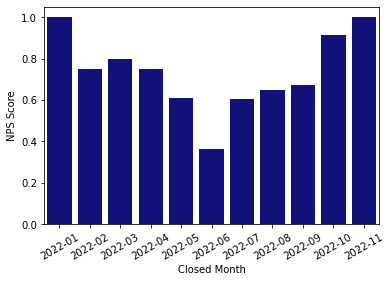

In [3]:
def func(x):
    promoter_ct = x.isin([9,10]).sum()
    detractor_ct = x.isin([0,1,2,3,4,5,6]).sum()
    return (promoter_ct - detractor_ct)/len(x)

nps_df = df[['NPS Score', 'Closed Date']]
nps_df = nps_df[~nps_df['NPS Score'].isnull()]
nps_df['Closed Month'] = pd.to_datetime(df['Closed Date']).dt.to_period('M')
nps_by_month = nps_df.groupby('Closed Month')['NPS Score'].agg([func])
data = nps_by_month.reset_index().rename(columns={'func':'NPS Score'})

sns.barplot(data=data, x='Closed Month', y='NPS Score', color = 'darkblue')
plt.xticks(rotation=30)

NPS Score = [promoter (9-10) - detractor (0-6)] / total responses

NPS were good in January, October, and November. NPS score readily decreased until June and then recovers since then.

### How does job function affect search outcomes?

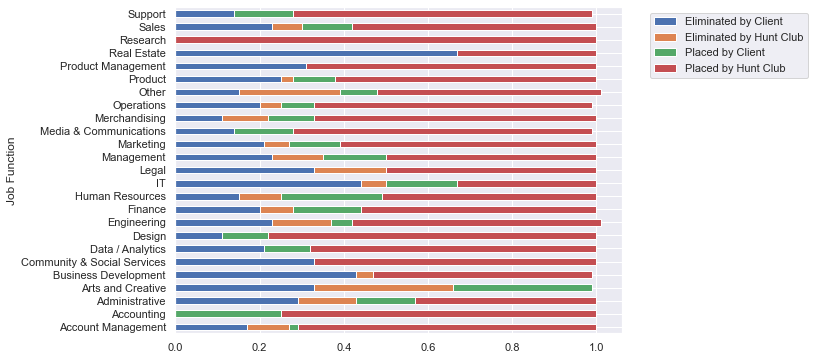

In [4]:
ct_by_job_function = df.groupby('Job Function').count()['Req ID'].to_frame().rename(columns={'Req ID':'Total Count'})
ct_by_job_and_outcomes = df.groupby(['Job Function','Search Outcome'])['Req ID'].count().to_frame().reset_index()
tb = pd.merge(left=ct_by_job_and_outcomes, right=ct_by_job_function, on='Job Function')
tb['Occurance rate'] = tb.apply(lambda x: round(x['Req ID'] / x['Total Count'],2), axis = 1)
data = tb.drop(columns = ['Req ID', 'Total Count'])
sns.set()
data = pd.pivot_table(data, columns='Search Outcome', index='Job Function', values='Occurance rate')
data.plot(kind='barh', stacked=True, figsize=(8,6))
plt.legend(bbox_to_anchor=(1.05, 1))


- Some observations:
    - `Research` is fully placed by Hunt Club
    - `Ars and Creative` is largely placed by client or eliminated by Hunt Club (a.k.a never placed by Hunt Club)
    - Relatively rarely eliminated by Hunt Club, except for `Arts and Creative`, `Legal`, and `Other`
    - `Real Estate` is either placed by Hunt Club or eliminated by Client (a.k.a client can't find the candidates themselves)
    - Hung Club can improve on `IT` because the rate of eliminated by client is higher than the rate of placed by Hunt Club

### What key factors lead to a quality or successful search experience?

In [5]:
base = df[['Remote Work Option', 'Search Outcome', 'Total Comp ($)', 'Total Candidates', 'Responsive Candidates', 'Presented Candidates', 'Offered Candidates']]
not_successful = base[base['Search Outcome'].isin(['Eliminated by Client', 'Eliminated by Hunt Club'])]
not_successful.describe()

,Remote Work Option,Total Comp ($),Total Candidates,Responsive Candidates,Presented Candidates,Offered Candidates
count,169.000,346.000,387.000,387.000,387.000,387.000
mean,0.757,183037.682,406.667,91.873,11.682,0.496
std,0.430,76373.870,381.743,76.243,9.914,1.078
min,0.000,5000.000,0.000,0.000,0.000,0.000
25%,1.000,130000.000,194.500,40.000,5.000,0.000
50%,1.000,175000.000,312.000,77.000,10.000,0.000
75%,1.000,225000.000,528.500,119.000,16.000,1.000
max,1.000,400000.000,3675.000,486.000,57.000,8.000


In [6]:
successful = base[~base['Search Outcome'].isin(['Eliminated by Client', 'Eliminated by Hunt Club'])]
successful.describe()

,Remote Work Option,Total Comp ($),Total Candidates,Responsive Candidates,Presented Candidates,Offered Candidates
count,485.000,916.000,919.000,919.000,919.000,919.000
mean,0.779,208814.584,389.666,86.224,11.970,1.417
std,0.415,113442.869,383.940,70.713,8.848,1.176
min,0.000,10000.000,1.000,0.000,0.000,0.000
25%,1.000,140000.000,192.000,44.000,6.000,1.000
50%,1.000,190000.000,292.000,68.000,10.000,1.000
75%,1.000,252250.000,466.500,109.000,15.000,2.000
max,1.000,2100000.000,3675.000,489.000,57.000,8.000


- Some observations in terms of Successful search experience:
    - slightly more remote work options (78% vs. 76%)
    - higher compensatoin (208K vs. 183K)
    - slightly less responsive candidates but similar number of presented candidates
    - almost 3x more candidates were selected by the client as the best fit